# Guía 1

## P300

### importacion de bibliotecas y definición de funciones

In [30]:
import os
import numpy as np
import scipy.io as spio
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def butter_bandpass_filter(data, frecuencias, sampling_freq, order, axis):
	frecuencias = [frecuencias[i]/(sampling_freq/2) for i in range(len(frecuencias))]
	b, a = signal.butter(order, frecuencias, btype='band')
	y = signal.filtfilt(b, a, data, axis = axis, padlen = None)
	return y


def find_indexes_P300(nombre, path='Datos/P300_S01'):
	
	data = spio.loadmat('{}/{}.mat'.format(path, nombre))
	stims_begin = data['stimulusbegin']
	stims_type = data['stimulustype']
	samples = data['senial']

	stim_indexes = []
	stim_labels = []
	for i in range(len(stims_begin)-1):
		if stims_begin[i+1]-stims_begin[i] == 1:
			if stims_type[i+1] - stims_type[i] == 1:
				stim_indexes.append(i+1)
				stim_labels.append('target')
			else:
				stim_indexes.append(i+1)
				stim_labels.append('non_target')

	return stim_indexes, stim_labels, samples


def extract_trial_P300(nombres, orden_filtro, frecuencias, downsample):
	trials = {}
	sampling_freq = 256
	
	trials =[]
	stim_labels_final = []
	for nombre in nombres: 
		stim_indexes, stim_labels, samples = find_indexes_P300(nombre)
		stim_labels_final.extend(stim_labels)
		
		for i in stim_indexes:
			trials.append(butter_bandpass_filter(samples[i:i+sampling_freq], frecuencias, sampling_freq, orden_filtro, 0))
	
	if downsample > 1:
		for i in range(len(trials)):
			trials[i] = trials[i][::int(downsample)]
		
	return trials, stim_labels_final


def get_indexes(stim_labels, stim_code):
	indexes = []
	for i in range(len(stim_labels)):
		if stim_labels[i] == stim_code:
			indexes.append(i)
	return indexes


def channel_means(trials, stim_indexes):
	channel = []
	for col in range(len(trials[0][0])):
		col = 0
		lista_cols = []
		for fila in range(len(trials[0][:,0])):
			lista_filas = []
			for trial in stim_indexes:
				lista_filas.append(trials[trial][fila,col])
			lista_cols.append(np.mean(lista_filas))
		channel.append(lista_cols)
	return channel
		

def dynamic_plot(trials, stim_indexes_1, stim_indexes_2):
	fig = plt.figure()
	ax1 = fig.add_subplot(1,1,1)

	for i in range(int(len(stim_indexes_1)/2)):
		channel_stim_1 = channel_means(trials, stim_indexes_1[:2*(i+1)])
		channel_stim_2 = channel_means(trials, stim_indexes_2[:2*(i+1)])
		
		ax1.clear()
		ax1.grid()
		ax1.plot(channel_stim_1[0], label = 'Target stimulus')
		ax1.plot(channel_stim_2[0], label = 'Non taget stimulus')
		ax1.set_title('promedio sobre {} trials'.format(2*(i+1)), color = 'white')
		ax1.tick_params(color = 'white', labelcolor = 'white')
		ax1.legend()
		display(fig)
		clear_output(wait = True)  
		plt.pause(0.05)



### Corrida

KeyboardInterrupt: 

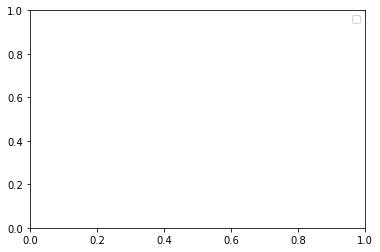

In [29]:
nombres = ['ACS11_bis', 'ACS12_bis', 'ACS13_bis']
orden_filtro = 3
frecuencias = [1, 12]
downsample = 1

trials_P300, stim_labels_P300 = extract_trial_P300(nombres, orden_filtro, frecuencias, downsample)
target_indexes = get_indexes(stim_labels_P300, 'target')
non_target_indexes = get_indexes(stim_labels_P300, 'non_target')
dynamic_plot(trials_P300, target_indexes, non_target_indexes)

## Motor Imagery

### Importacion de módulos y definición de funciones

In [10]:
import os
import numpy as np
import scipy.io as spio
from scipy import signal
import matplotlib.pyplot as plt


def butter_bandpass_filter(data, frecuencias, sampling_freq, order, axis):
	frecuencias = [frecuencias[i]/(sampling_freq/2) for i in range(len(frecuencias))]
	b, a = signal.butter(order, frecuencias, btype='band')
	y = signal.filtfilt(b, a, data, axis = axis, padlen = None)
	return y


def find_indexes_MI(nombre, stim_codes, canales, path = 'Datos/MI_S01'):
	
	data = spio.loadmat('{}/{}.mat'.format(path, nombre))
	sample_time = data['sampleTime']
	sampling_freq = data['samplingFreq'][0][0]
	stims = data['stims']
	muestras = np.transpose(data['samples'])
	channels = [data['channelNames'][0][i][0]for i in range(len(data['channelNames'][0]))]
	
	if canales:
		samples = {}
		for i, channel in enumerate(channels):
			if channel in canales:
				samples.append(muestras[i])
		samples = np.transpose(samples)
	else:
		samples = np.transpose(muestras)
	
	stim_indexes = []
	stim_labels = []
	for i in range(len(stims[:,0])):
		if (any (stims[i,1] == stim_codes[j] for j in range(len(stim_codes)))):
			stim_indexes.append(int(stims[i,0]*sampling_freq))
			stim_labels.append(stims[i,1])
			
	return stim_indexes, stim_labels, samples, sampling_freq


def extract_trial_MI(nombres, stim_codes, canales, orden_filtro, frecuencias, downsample):
	trials = []
	stim_labels_final = []
	
	for nombre in nombres:
		stim_indexes, stim_labels, samples, sampling_freq = find_indexes_MI(nombre, stim_codes, canales)
		stim_labels_final.extend(stim_labels)
	
		for i in stim_indexes:
			trials.append(butter_bandpass_filter(samples[i-3*sampling_freq:i+5*sampling_freq], frecuencias, sampling_freq, orden_filtro, 0))
	
	if downsample > 1:
		for i in range(len(trials)):
			trials[i] = trials[i][::int(downsample)]
	
	return trials, stim_labels_final


def get_indexes(stim_labels, stim_code):
	indexes = []
	for i in range(len(stim_labels)):
		if stim_labels[i] == stim_code:
			indexes.append(i)
	return indexes


def channel_means(trials, stim_indexes):
	channel = []
	for col in range(len(trials[0][0])):
		col = 0
		lista_cols = []
		for fila in range(len(trials[0][:,0])):
			lista_filas = []
			for trial in stim_indexes:
				lista_filas.append(trials[trial][fila,col])
			lista_cols.append(np.mean(lista_filas))
		channel.append(lista_cols)
	return channel
		


### Corrida

In [ ]:
nombres = ['S01_FILT_S1R1', 'S01_FILT_S1R2', 'S01_FILT_S1R3', 'S01_FILT_S1R4']
stim_codes = [770, 772]
canales = '’F5’;’F3’;’F1’;’Fz’;’F2’;’F4’;’F6’;’FC5’;’FC3’;’FC1’;’FCz’;’FC2’;’FC4’;’FC6’;’C5’;’C3’;’C1’;’Cz’;’C2’;’C4’;’C6’;’CP5’;’CP3’;’CP1’;’CPz’;’CP2’;’CP4’;’CP6’'.replace(';',',').replace(' ', '').replace('’', '').split(',')   
orden_filtro = 2
frecuencias = [0.1, 40]
downsample = 1
trials_MI, stim_labels = extract_trial_MI(nombres, stim_codes, canales, orden_filtro, frecuencias, downsample)

trials_MI_8_11 = [butter_bandpass_filter(trials_MI[i], [8, 11], 512, 2, 0)**2 for i in range(len(trials_MI))]
trials_MI_26_30 = [butter_bandpass_filter(trials_MI[i], [26, 30], 512, 2, 0)**2 for i in range(len(trials_MI))]

indexes_770 = get_indexes(stim_labels, 770)
indexes_772 = get_indexes(stim_labels, 772)

for j in [indexes_770, indexes_772]:
	for trials in [trials_MI_8_11, trials_MI_26_30]:
		channels_final = channel_means(trials, j)
		plt.figure()
		plt.plot(channels_final[14])
		plt.figure()
		plt.plot(channels_final[16])